In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class SPOTDataLoader(Dataset):
    def __init__(self, root_dir, labels_file, transform=None, preload=False):
        print("Initializing SPOTDataLoader...")
        self.root_dir = root_dir
        self.transform = transform
        self.labels = np.load(labels_file)

        self.preload = preload
        self.cached_data = {}

        if self.preload:
            print("Preloading dataset into memory... This may take time.")
            for idx in range(len(self.labels)):
                folder_name = format(idx, '05d')
                folder_path = os.path.join(self.root_dir, folder_name)

                input_images = []
                for i in range(5):
                    img_path = os.path.join(folder_path, f"{i}.jpg")
                    image = Image.open(img_path).convert('RGB')
                    if self.transform:
                        image = self.transform(image)
                    input_images.append(image)

                goal_image_path = os.path.join(folder_path, f"goal.jpg")
                goal_image = Image.open(goal_image_path).convert('RGB')
                if self.transform:
                    goal_image = self.transform(goal_image)

                self.cached_data[idx] = (torch.stack(input_images, dim=0), goal_image.unsqueeze(0), torch.tensor(self.labels[idx]))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.preload:
            return self.cached_data[idx]

        folder_name = format(idx, '05d')
        folder_path = os.path.join(self.root_dir, folder_name)

        input_images = []
        for i in range(5):
            img_path = os.path.join(folder_path, f"{i}.jpg")
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            input_images.append(image)

        goal_image_path = os.path.join(folder_path, f"goal.jpg")
        goal_image = Image.open(goal_image_path).convert('RGB')
        if self.transform:
            goal_image = self.transform(goal_image)

        return torch.stack(input_images, dim=0), goal_image.unsqueeze(0), torch.tensor(self.labels[idx])

In [6]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads=8):
        super(CrossAttentionBlock, self).__init__()
        # initializing multihead attention for processing features
        self.mha = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, query, key_value):
        B, C, H, W = query.shape
        # flattening spatial dimensions for performing attention
        query_flat = query.view(B, C, -1).permute(2, 0, 1)
        key_value_flat = key_value.view(B, C, -1).permute(2, 0, 1)
        # applying multihead attention
        attn_output, _ = self.mha(query_flat, key_value_flat, key_value_flat)
        # reshaping attended features back
        attn_output = attn_output.permute(1, 2, 0).view(B, C, H, W)
        return attn_output

class SharedResNet18MLP(nn.Module):
    def __init__(self):
        super(SharedResNet18MLP, self).__init__()
        # loading pretrained ResNet18
        base_resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.shared_trunk = nn.Sequential(*list(base_resnet.children())[:-2])
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        num_trunk_channels = 512
        self.num_cameras = 5

        # setting up camera-specific heads for current images
        self.current_heads = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(num_trunk_channels, num_trunk_channels, kernel_size=1),
                nn.ReLU(inplace=True)
            ) for _ in range(self.num_cameras)
        ])

        # setting up camera-specific heads for goal images
        self.goal_heads = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(num_trunk_channels, num_trunk_channels, kernel_size=1),
                nn.ReLU(inplace=True)
            ) for _ in range(self.num_cameras)
        ])

        # cross-attention block
        self.cross_attention = CrossAttentionBlock(embed_dim=num_trunk_channels, num_heads=8)

        # FC layers
        # input dimension is 5 cameras * 2 (current + goal) * 512 channels = 5120
        self.fc_layer1 = nn.Sequential(
            nn.Linear(5120, 1024),
            nn.ReLU()
        )
        self.fc_layer2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU()
        )
        self.fc_layer3 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU()
        )
        self.fc_layer4 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU()
        )
        # final layer outputting 3 regression values
        self.fc_layer5 = nn.Linear(1024, 3)

    def forward(self, current_images, goal_image):
        batch_size = current_images.size(0)
        current_features_list = []
        goal_features_list = []

        goal_image = goal_image.squeeze(1)
        # processing the goal image through shared trunk
        goal_trunk_feat = self.shared_trunk(goal_image)  # shape: (B, 512, H', W')

        for cam_idx in range(self.num_cameras):
            # processing current image for each camera
            curr = current_images[:, cam_idx, :, :, :]  # shape: (B, C, H, W)
            curr_feat = self.shared_trunk(curr)         # shape: (B, 512, H', W')
            curr_feat = self.current_heads[cam_idx](curr_feat)

            # processing goal image using camera-specific head
            goal_feat = self.goal_heads[cam_idx](goal_trunk_feat)

            # applying cross-attention in both directions
            curr_attended = curr_feat + self.cross_attention(curr_feat, goal_feat)
            goal_attended = goal_feat + self.cross_attention(goal_feat, curr_feat)

            # global pooling
            curr_pooled = self.global_pool(curr_attended).view(batch_size, -1)  # shape: (B, 512)
            goal_pooled = self.global_pool(goal_attended).view(batch_size, -1)  # shape: (B, 512)

            current_features_list.append(curr_pooled)
            goal_features_list.append(goal_pooled)

        # concatenating features
        current_features = torch.cat(current_features_list, dim=1)  # shape: (B, 5*512)
        goal_features = torch.cat(goal_features_list, dim=1)        # shape: (B, 5*512)
        features = torch.cat([current_features, goal_features], dim=1)  # shape: (B, 5120)

        # fc
        x = self.fc_layer1(features)
        x = self.fc_layer2(x)
        x = self.fc_layer3(x)
        x = self.fc_layer4(x)
        output = self.fc_layer5(x)  # final shape: (B, 3)
        return output


In [8]:
import os
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

# === Paths ===
SPLIT_DATA_PATH = '/content/drive/MyDrive/Spot_IL/Real World Dataset'
LABEL_PATH = os.path.join(SPLIT_DATA_PATH, 'map01_01_train_5_1/labels.npy')
TRAIN_PATH = os.path.join(SPLIT_DATA_PATH, 'map01_01_train_5_1')

WEIGHT_PATH = os.path.join(SPLIT_DATA_PATH, 'weights/map01_01_Resnet18Mlp')
os.makedirs(WEIGHT_PATH, exist_ok=True)

FIGURE_PATH = os.path.join(SPLIT_DATA_PATH, 'Results/map01_01_Resnet18Mlp')
os.makedirs(FIGURE_PATH, exist_ok=True)

# === Data Transforms ===
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === Device Setup ===
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')

# === Dataset ===
full_dataset = SPOTDataLoader(
    root_dir=TRAIN_PATH,
    labels_file=LABEL_PATH,
    transform=data_transforms,
    preload=True
)
print(f'Total training samples: {len(full_dataset)}')

BATCH_SIZE = 32
train_dataloader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# === Hyperparameters & Loss ===
LEARNING_RATE = 1e-3
NUM_EPOCHS = 500
LOSS_SCALE = 1e3
TOLERANCE = 1e-1
loss_fn = torch.nn.MSELoss()

# === Model, Optimizer, and Scheduler ===
model = SharedResNet18MLP().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

training_losses = []
train_accuracies = []

# === Training Loop ===
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for current_images, goal_images, labels in train_dataloader:
        current_images = current_images.to(DEVICE)
        goal_images = goal_images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        output = model(current_images, goal_images)  # (B, 3)

        # Computing loss
        loss = loss_fn(output, labels.float()) * LOSS_SCALE
        loss.backward()

        # Applying gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        running_loss += loss.item()

        # Computing accuracy
        errors = torch.norm(output - labels.float(), dim=1, p=2)
        train_correct += (errors < TOLERANCE).sum().item()
        train_total += errors.numel()

    # Loss and accuracy per epoch
    epoch_loss = running_loss / len(train_dataloader)
    train_accuracy = (train_correct / train_total) * 100
    training_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch}/{NUM_EPOCHS} -- Training Loss: {epoch_loss:.6f} -- Training Accuracy: {train_accuracy:.2f}%")

    # Adjusting learning rate if model is not improving
    scheduler.step(epoch_loss)

    # --- Saving Weights Every 25 Epochs ---
    if epoch % 25 == 0:
        weight_file = os.path.join(WEIGHT_PATH, f'epoch_{epoch}.pth')
        torch.save(model.state_dict(), weight_file)
        print(f"Weights saved at epoch {epoch}")

# === Final Model Save ===
final_weight_file = os.path.join(WEIGHT_PATH, f'final_epoch_{NUM_EPOCHS}.pth')
torch.save(model.state_dict(), final_weight_file)
print("Training complete. Final model saved.")


Using device: cuda
Initializing SPOTDataLoader...
Preloading dataset into memory... This may take time.
Total training samples: 1993
Epoch 1/500 -- Training Loss: 249.850293 -- Training Accuracy: 18.87%
Epoch 2/500 -- Training Loss: 122.985237 -- Training Accuracy: 31.76%
Epoch 3/500 -- Training Loss: 100.120800 -- Training Accuracy: 30.96%
Epoch 4/500 -- Training Loss: 90.191420 -- Training Accuracy: 33.57%
Epoch 5/500 -- Training Loss: 79.014094 -- Training Accuracy: 33.37%
Epoch 6/500 -- Training Loss: 78.695969 -- Training Accuracy: 33.77%
Epoch 7/500 -- Training Loss: 66.054819 -- Training Accuracy: 34.92%
Epoch 8/500 -- Training Loss: 58.597172 -- Training Accuracy: 35.88%
Epoch 9/500 -- Training Loss: 57.366831 -- Training Accuracy: 35.73%
Epoch 10/500 -- Training Loss: 53.231620 -- Training Accuracy: 36.73%
Epoch 11/500 -- Training Loss: 46.803530 -- Training Accuracy: 36.63%
Epoch 12/500 -- Training Loss: 40.005783 -- Training Accuracy: 37.98%
Epoch 13/500 -- Training Loss: 37

KeyboardInterrupt: 

In [14]:
import matplotlib.pyplot as plt
import os

WEIGHT_SAVING_STEP = 10
DPI = 120
FIGURE_SIZE_PIXEL = [2490, 1490]
FIGURE_SIZE = [fsp / DPI for fsp in FIGURE_SIZE_PIXEL]

def plot_graph(training_losses, train_accuracies, figure_path=None,
               loss_filename='Training_loss.png', accuracy_filename='Training_accuracy.png',
               start_plot=0, end_plot=None):
    if end_plot is None or end_plot > len(training_losses):
        end_plot = len(training_losses)

    epochs = range(start_plot + 1, end_plot + 1)

    # ===== Training Loss =====
    plt.figure(figsize=FIGURE_SIZE, dpi=DPI)
    plt.scatter(epochs, training_losses[start_plot:end_plot], color='blue', label='Training Loss')
    plt.plot(epochs, training_losses[start_plot:end_plot], color='cyan', linestyle='-', label='Loss Trend')
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (scaled)")
    plt.legend()

    lowest_loss = min(training_losses[start_plot:end_plot])
    for i, loss in enumerate(training_losses[start_plot:end_plot], start=start_plot+1):
        if (i % WEIGHT_SAVING_STEP == 0) or (i == end_plot):
            plt.annotate(str(round(loss, 6)), xy=(i, loss))

    plt.text(0, plt.gca().get_ylim()[1], f'Lowest Loss: {lowest_loss:.6f}')

    if figure_path is not None:
        plt.savefig(os.path.join(figure_path, loss_filename))
    plt.show()

    # ===== Training Accuracy =====
    plt.figure(figsize=FIGURE_SIZE, dpi=DPI)
    plt.plot(epochs, train_accuracies[start_plot:end_plot], color='green', linestyle='-', marker='o',
             label='Training Accuracy')
    plt.title("Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    for i, acc in enumerate(train_accuracies[start_plot:end_plot], start=start_plot+1):
        if (i % WEIGHT_SAVING_STEP == 0) or (i == end_plot):
            plt.annotate(f"{round(acc, 2)}", xy=(i, acc))

    if figure_path is not None:
        plt.savefig(os.path.join(figure_path, accuracy_filename))
    plt.show()


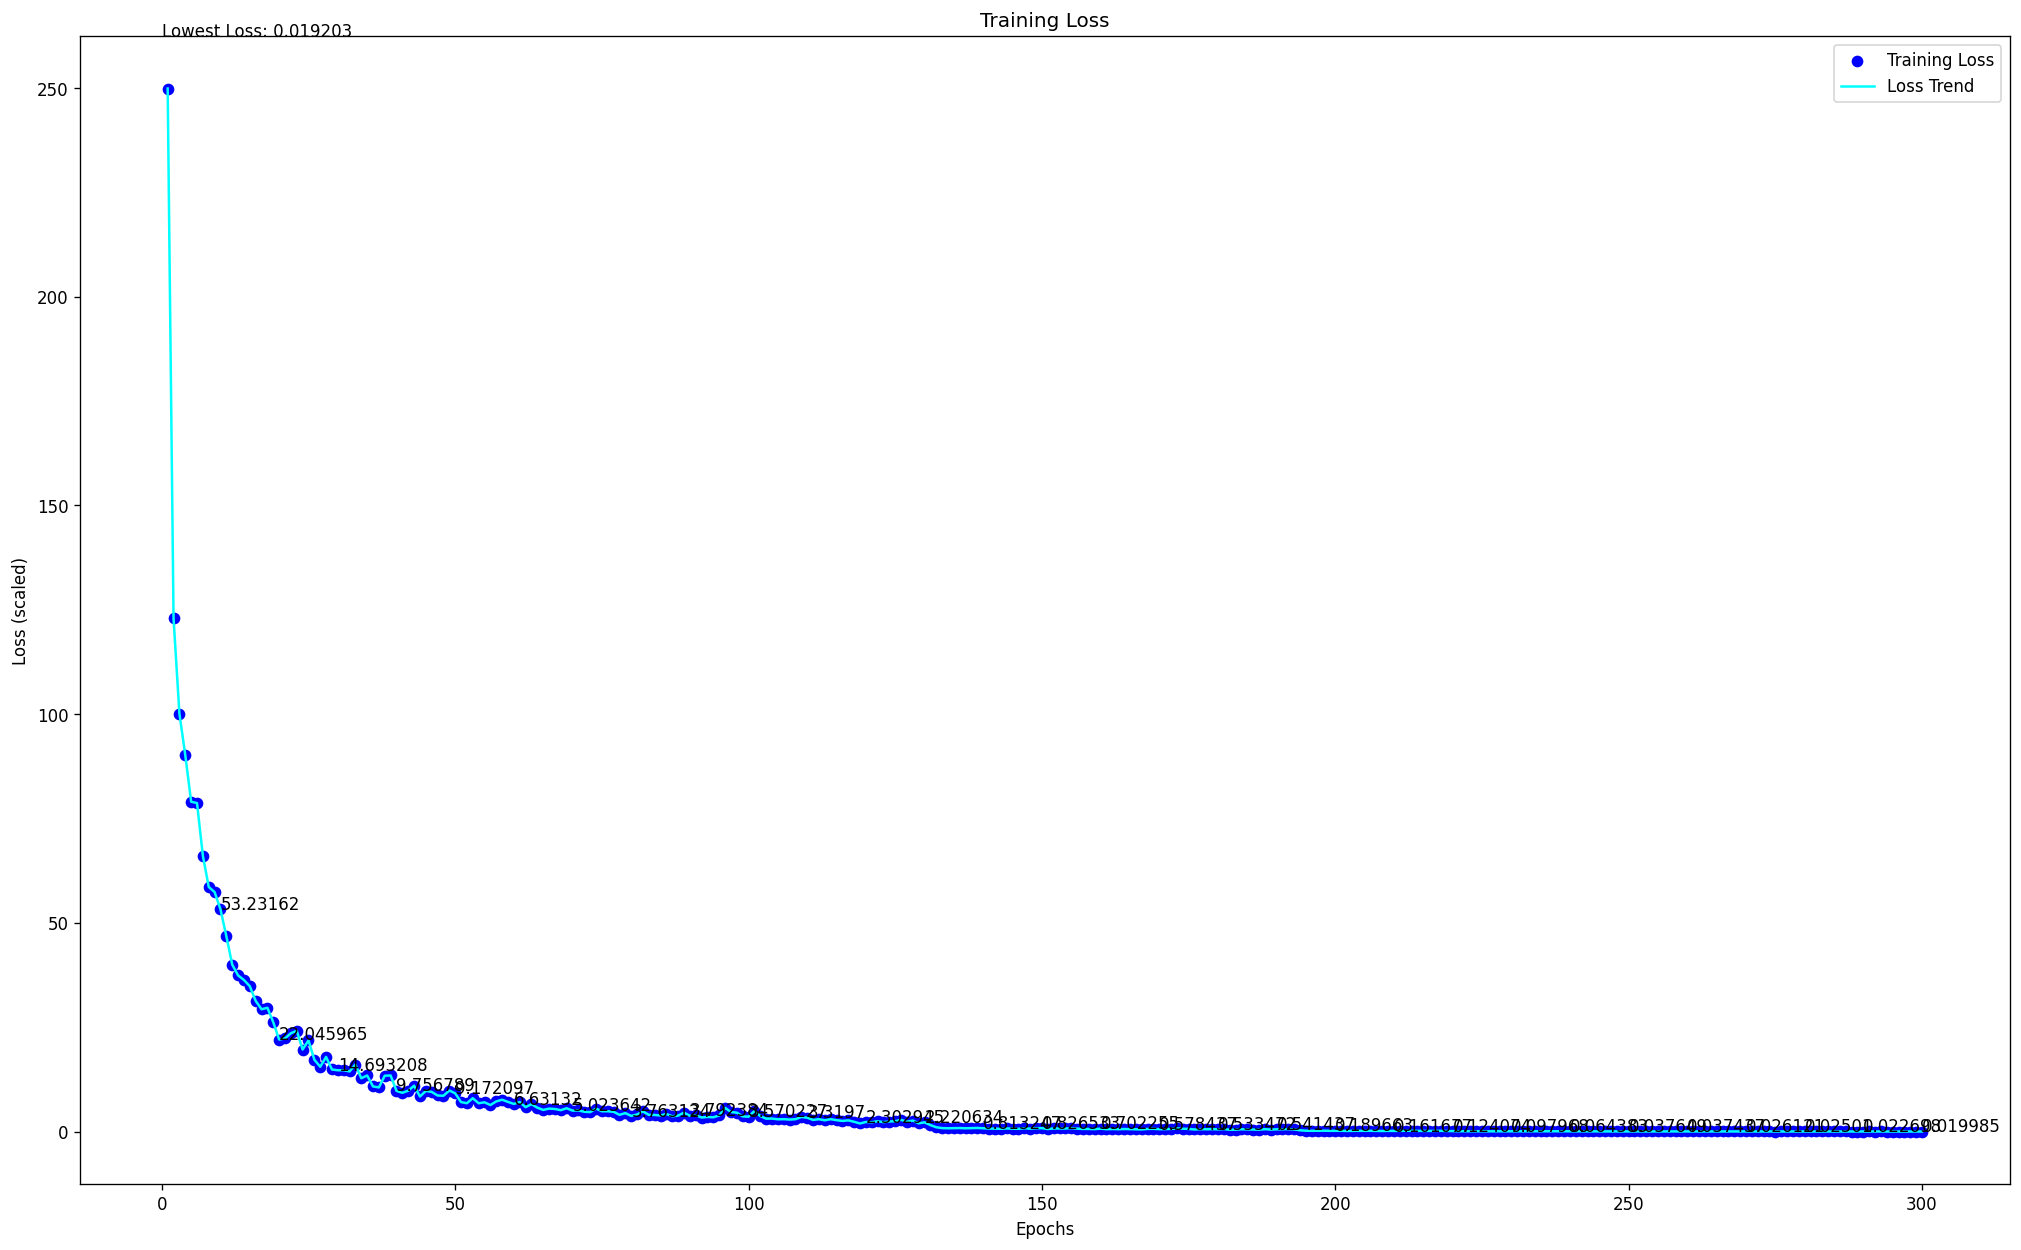

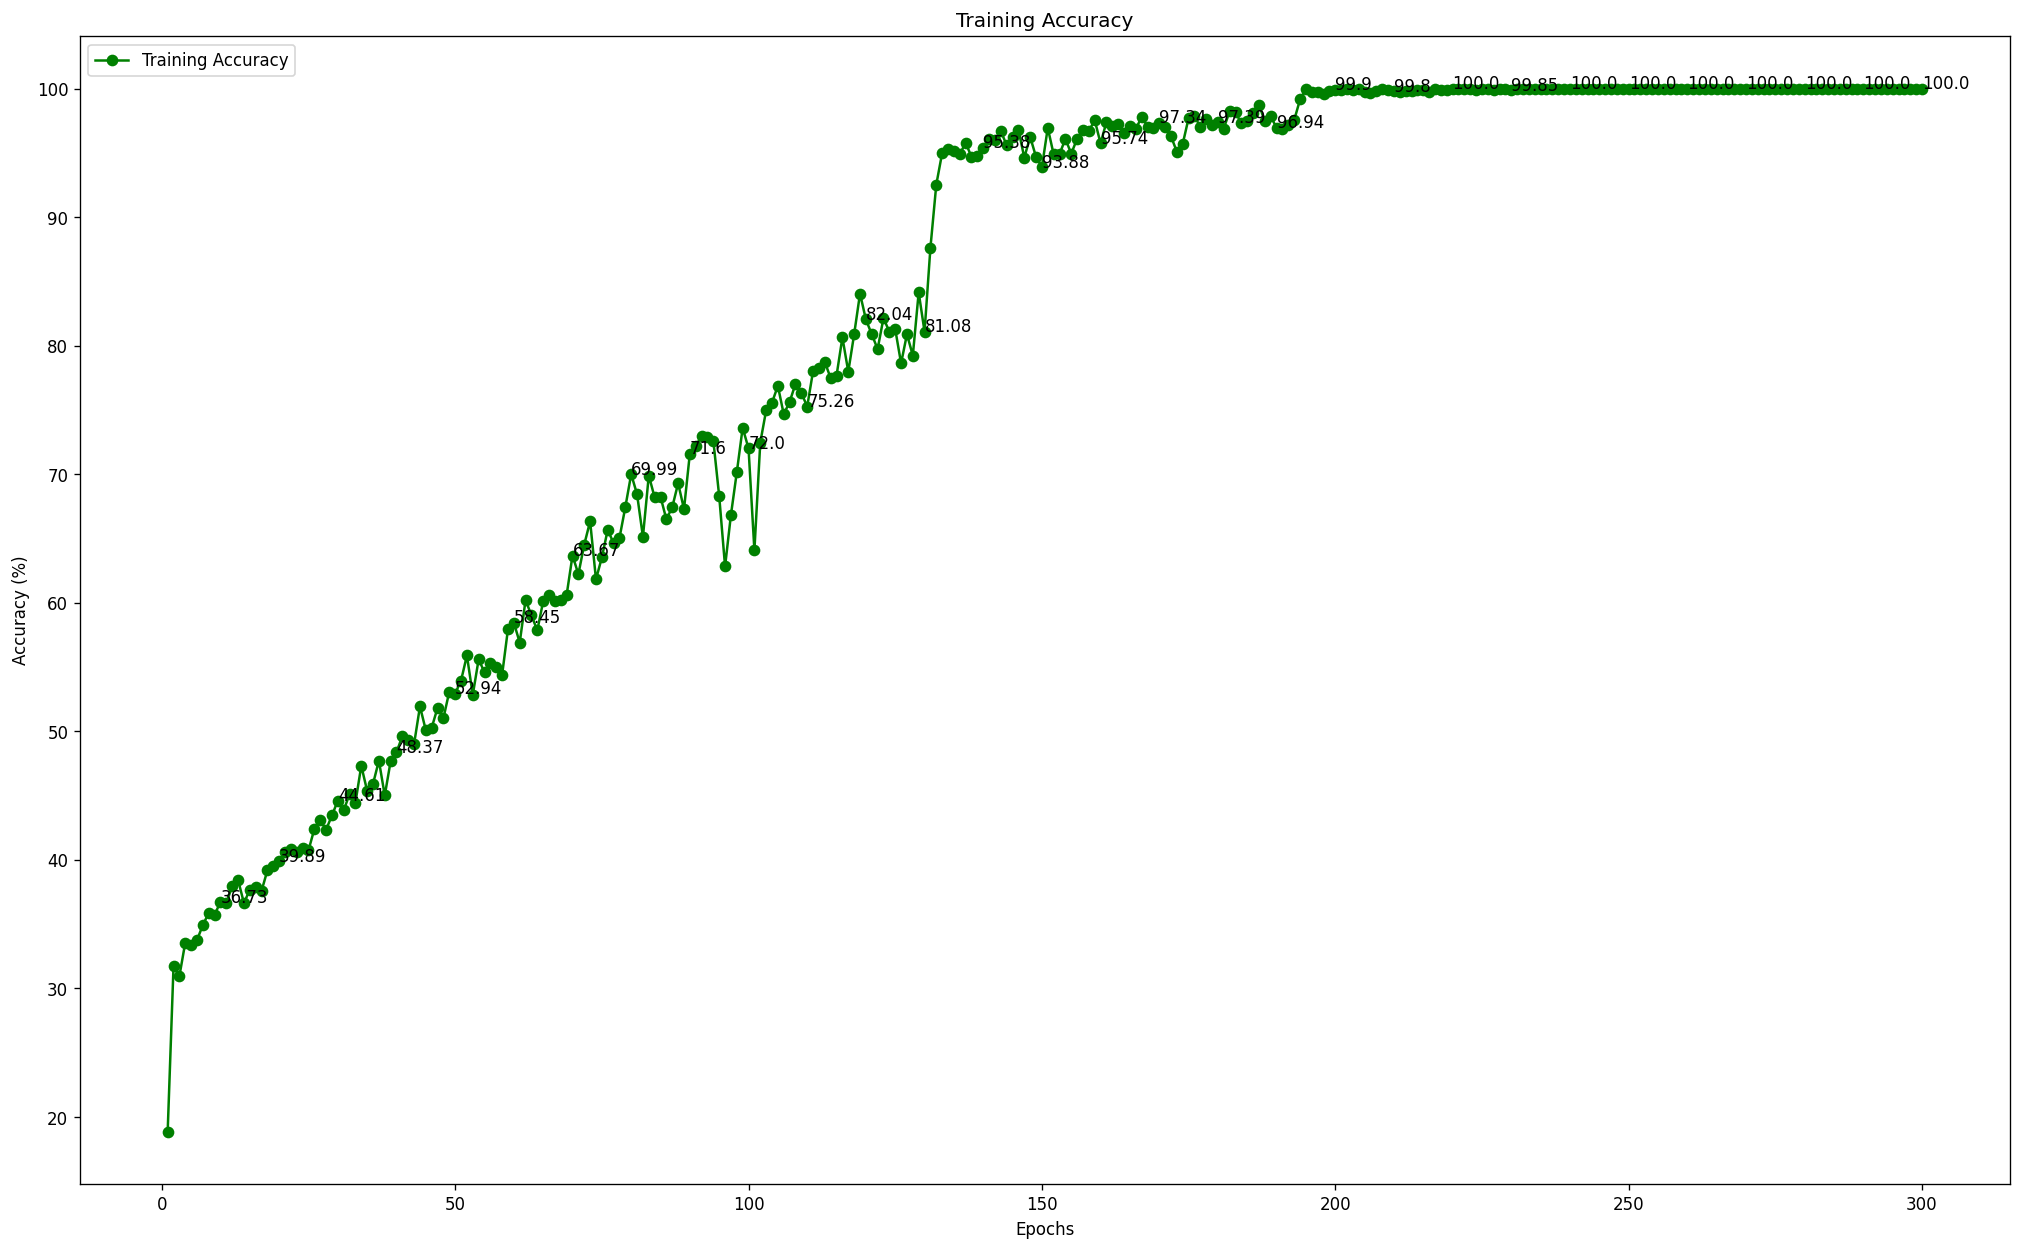

In [17]:
plot_graph(training_losses, train_accuracies, FIGURE_PATH,
               loss_filename='Training_loss.png', accuracy_filename='Training_accuracy.png',
               start_plot=0, end_plot=300)

In [10]:
training_history = {
    'losses': training_losses,
    'accuracies': train_accuracies
}

history_file = os.path.join(FIGURE_PATH, 'resnet18_training_history.pth')
torch.save(training_history, history_file)
print(f"Training history saved to {history_file}")

Training history saved to /content/drive/MyDrive/Spot_IL/Real World Dataset/Results/map01_01_Resnet18Mlp/resnet18_training_history.pth
